# 1 Author

**Student Name**: Pradnya Gade

**Student ID**:  210059058



# 2 Problem formulation

Problem :
Using the MLEnd Hums and Whistles dataset, build a machine learning pipeline that takes as an input a Potter or a StarWars audio segment and predicts its song label (either Potter or StarWars).

As a part of this problem, we are provided with the information such as the Participant id ,interpretation type (hum/whistle), interpretation number(1-4) for each participant and the name of song(Harry/StarWars) . Using this information, we have to predict if the song label is Potter or StarWars.

# 3 Machine Learning pipeline

I would like to define my pipeline as shown below:

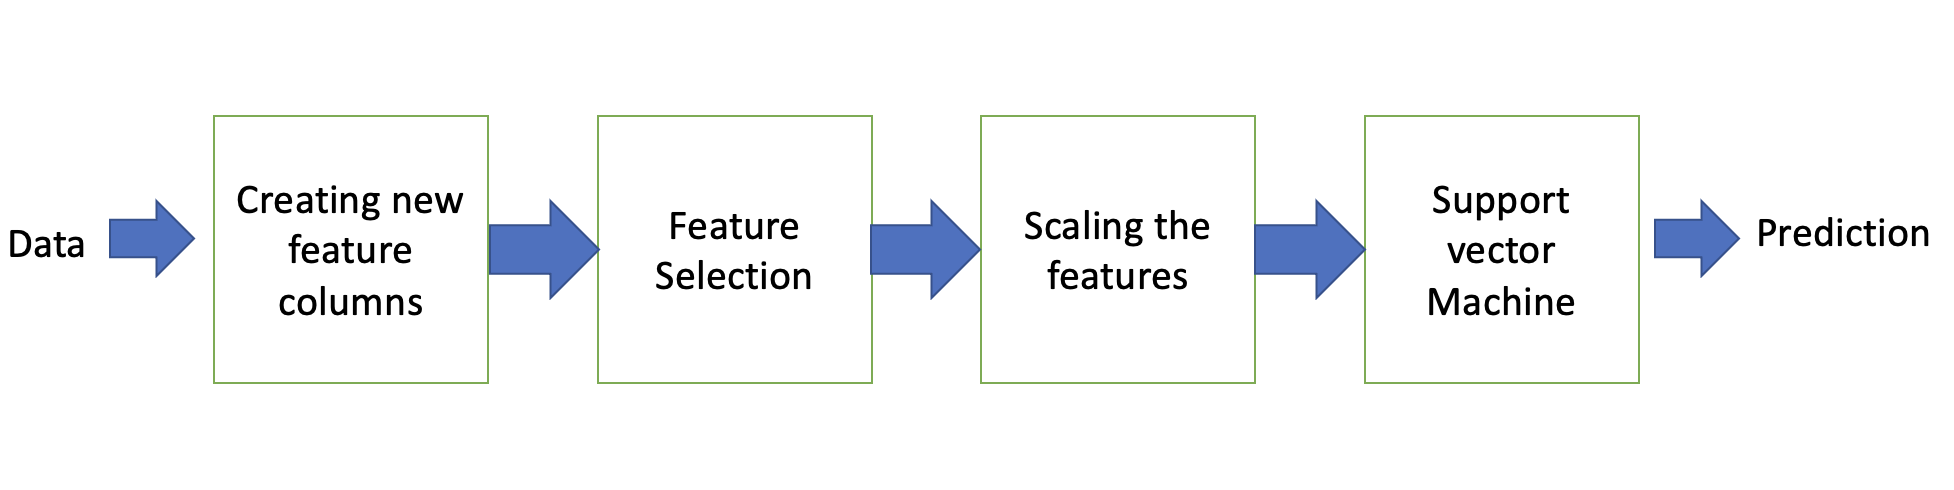

In [65]:
from IPython.display import Image
Image('Pipeline.png')

Pipeline consists of below mentioned stages

1. Create new columns to add features
2. Perform required data preprocessing and transformations
3. Build a model to predict the song


Loading useful Python libraries and mounting my personal Google Drive storage system

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


# 4 Transformation stage

At this stage I have listed down the set of features and necessary preprocessing steps (for each of them) to be used in the machine learning pipeline.

1.   Pitch
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.
5.   Zero crossings rate : It can be defined as the number of times the signal changes value, from positive to negative and vice versa, divided by the length of the frame.It can be defined as a measure of the noisiness of a signal.This spectral characteristic showcases higher values in the case of noisy signals.
6.   Tempo : Tempo is the speed or pace at which a exhibit of music is played. The tempo can have any quantity of beats per minute. The lower the number of beats per minute, the slower the tempo. Inversely, the higher the number of beats per minute, the tempo will be faster. The portion of the audio which do not showcase salient harmonic progression may be frequently better characterized using tempo patterns.

For all the files these ablove six features are extracted with the help of getPitch and getXy function defined below.

In [4]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [5]:
def getXy(training_data,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(training_data):
    fileID = preProcess(file).split('/')[-1].strip().lower()
    yi = labels_file.loc[fileID]['song'].lower()=='potter'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    zero_crossings = librosa.zero_crossings(x, pad=False)
    onset_env = librosa.onset.onset_strength(x, sr=fs)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=fs)

    xi = [power,pitch_mean,pitch_std,voiced_fr,sum(zero_crossings),tempo[0]]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

y will contain 'True' for Potter and 'False' for Starwars.

Extracting all the six features for the files:

In [20]:
X,y = getXy(files, labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 824/824 [1:13:19<00:00,  5.34s/it]


Normalizing the data:
Scaling and translating each feature individually such that it is in the range of (-1,1). 

In [56]:
import sklearn
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(X)

Splitting the files into training, validation and testing.
I will train all the models on the training data and check it’s performance on the validation data. 

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features_scaled,y,test_size=0.3,random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((576, 6), (248, 6), (576,), (248,))

# 5 Modelling

ML models implemented : 

1. Logistic Regression 
2. Naive Bayes
3. Random Forrest
4. Support Vector Machine

# 6 Methodology

Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)

Train and validation sets are ready. Let us train all the models on training data and check it’s performance on the validation data.
Calculated training and validation accuracy for all the models.Comparing the validation accuracy to arrive at the highest performing model.

In [38]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression

# Here we fit our logistic regression classfier to the training dataset 
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train,y_train)

yt_p = log_reg_classifier.predict(X_train)
yv_p = log_reg_classifier.predict(X_val)

print('Training Accuracy',log_reg_classifier.score(X_train,y_train))
print('Validation  Accuracy', log_reg_classifier.score(X_val,y_val))


Training Accuracy 0.7430555555555556
Validation  Accuracy 0.7298387096774194


In [37]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb_A = GaussianNB()
gnb_A.fit(X_train,y_train)

yt_p = gnb_A.predict(X_train)
yv_p = gnb_A.predict(X_val)

print('Training Accuracy',gnb_A.score(X_train,y_train))
print('Validation  Accuracy',gnb_A.score(X_val,y_val))


Training Accuracy 0.7309027777777778
Validation  Accuracy 0.7056451612903226


In [44]:
#Random Forrest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)

yt_p = clf.predict(X_train)
yv_p = clf.predict(X_val)

print('Training Accuracy',clf.score(X_train,y_train))
print('Validation  Accuracy',clf.score(X_val,y_val))

Training Accuracy 0.78125
Validation  Accuracy 0.7741935483870968


In [46]:
#SVM
from sklearn import svm

model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.7760416666666666
Validation  Accuracy 0.7741935483870968
The support vectors are (364, 6)


Trying out different values for the hyperparamater.

In [49]:
#SVM with C=4
from sklearn import svm

model  = svm.SVC(C=4)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.7760416666666666
Validation  Accuracy 0.782258064516129
The support vectors are (337, 6)


The best validation accuracy is obtained for SVM model with C=2 in comparision with all the other models

In [58]:
#SVM with C=2
from sklearn import svm

model  = svm.SVC(C=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.7690972222222222
Validation  Accuracy 0.7903225806451613
The support vectors are (349, 6)


In [62]:
from sklearn.metrics import classification_report
print(classification_report(yv_p,y_val))

              precision    recall  f1-score   support

       False       0.73      0.81      0.77       108
        True       0.84      0.77      0.81       140

    accuracy                           0.79       248
   macro avg       0.79      0.79      0.79       248
weighted avg       0.80      0.79      0.79       248



In [63]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_heatmap(y_validation, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_validation))   # get the labels in the y_test
   
    cm = confusion_matrix(y_validation, preds) #, labels
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=15)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
   
    plt.show()

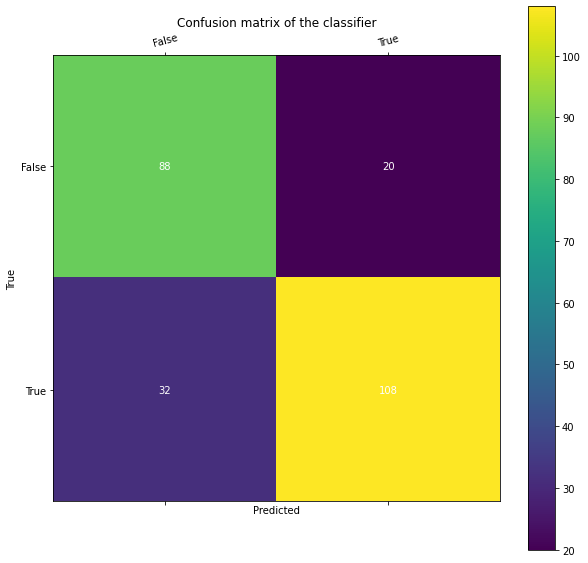

In [64]:
confusion_matrix_heatmap(yv_p,y_val)

Starwars was predicted as Potter 20 times.
Potter was predicted as Starwars 32 times.
Starwars was correctly predicted 88 times.
Potter was correctly predicted 108 times.

# 7 Dataset

Dataset includes data from four folders ['Potter_1', 'StarWars_1', 'StarWars_2', 'Potter_2'] containing 824 files extracted from personal Google Drive storage system.

In [6]:
path = '/content/drive/MyDrive/Data/Basic'
os.listdir(path)

['Potter_1', 'StarWars_1', 'StarWars_2', 'Potter_2']

In [16]:
potter_1_path = '/content/drive/MyDrive/Data/Basic/Potter_1/*.wav'
potter_2_path = '/content/drive/MyDrive/Data/Basic/Potter_2/*.wav'

starwars_1_path = '/content/drive/MyDrive/Data/Basic/StarWars_1/*.wav'
starwars_2_path = '/content/drive/MyDrive/Data/Basic/StarWars_2/*.wav'

files = glob.glob(potter_1_path)
files.extend(glob.glob(potter_2_path))
files.extend(glob.glob(starwars_1_path))
files.extend(glob.glob(starwars_2_path))

len(files)

824

Function takes each file and corrects the file name  
Parsing each file name and extract the naming convention [Participant ID]_[type of recording]_[interpretation number]_[song].  
returns edited file name'''

In [17]:
def preProcess(file):
  
  file = file.replace("[", "")
  file = file.replace("]", "")
  file = file.replace(" ", "_")
  file = file.replace(".", "_")
  file = '.'.join(file.rsplit('_', 1))
  return file

In [11]:
for file in files:
  file=preProcess(file)
  try:
    song = file.split('/')[-1].split('_')[3].split('.')[0].lower()
    interpretation = file.split('/')[-1].split('_')[1].lower()
    if song!= "potter" and song!="starwars" and song!="rain" and song!="hakuna" and song!="frozen" and song!="mamma" and song!="showman" and song!="panther":
      print("File:",file.split('/')[-1])
    if interpretation!="hum" and interpretation!="whistle":
      print("File:",file.split('/')[-1])   
  except:
    print("File:",file.split('/')[-1])

File: S38_hum_3_Potterwav.wav
File: S105_hum_1_harry_potter.wav
File: S55_harrypotter_hum_2.wav
File: S55_harrypotter_hum_2.wav
File: S55_harrypotter_whistle_1.wav
File: S55_harrypotter_whistle_1.wav
File: S146_hum_1_(potter).wav
File: S146_hum_3_(potter).wav
File: S138_whistle_1_Harry_Potter_Theme_Song.wav
File: S138_hum_1_Harry_Potter_Theme_Song.wav
File: S61_hum_2_StatWars.wav
File: S102_whistle_1_Star_wars.wav
File: S102_whistle_2_Star_wars.wav
File: S85_hum_3_StarsWars.wav
File: S85_hum_4_StarsWars.wav
File: S42_Hum2_StarWar.wav
File: S42_Hum3_StarWar.wav
File: S49_hum_2__Star_Wars_.wav
File: S49_hum_3__Star_Wars_.wav
File: S55_starwars_whistle_2.wav
File: S55_starwars_whistle_2.wav
File: S55_starwars_hum_1.wav
File: S55_starwars_hum_1.wav
File: S114_hum_4_star_wars.wav
File: S6_whisle_2_starwar.wav
File: S6_whisle_2_starwar.wav
File: S114_hum_3_star_wars.wav
File: S6_whisle_1_starwar.wav
File: S6_whisle_1_starwar.wav
File: S221_hum_1_StartWars.wav
File: S150_hum_1_imperial_march.

After correcting the above detected errors manually creating a dataframe below.

In [19]:
MLENDHW_table = [] 

for file in files:
  file = preProcess(file)
  file_name = file.split('/')[-1].strip().lower()
  participant_ID = file.split('/')[-1].split('_')[0]
  interpretation_type = file.split('/')[-1].split('_')[1].lower()
  interpretation_number = file.split('/')[-1].split('_')[2]
  song = file.split('/')[-1].split('_')[3].split('.')[0].lower()
  MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number,song])

MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
MLENDHW_df



,participant,interpretation,number,song
file_id,,,,
s40_whistle_2_potter.wav,S40,whistle,2,potter
s40_hum_2_potter.wav,S40,hum,2,potter
s103_hum_2_potter.wav,S103,hum,2,potter
s103_whistle_2_potter.wav,S103,whistle,2,potter
s17_hum_1_potter.wav,S17,hum,1,potter
...,...,...,...,...
s138_whistle_1_starwars.wav,S138,whistle,1,starwars
s134_hum_2_starwars.wav,S134,hum,2,starwars
s134_hum_1_starwars.wav,S134,hum,1,starwars


# 8 Results

Experimentation with different features.

Explored other features such as : 
1. Spectral Centroid 

Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

2. Spectral Roll-off

The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. 

3. MFCC

Mel-frequency cepstral coefficients 

Drawback :     
All of these features gave the characteristics of the audio in an array, which was difficult to import as a feature value.

In [68]:
#Spectral Centroid
y, sr = librosa.load(files[0])
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
cent

array([[5584.301964  , 5520.93030415, 5057.41120715, 4648.03325405,
        4491.78357757, 4369.12709765, 4124.53526803, 4033.28770569,
        3581.32068135, 3253.4481035 , 3041.86772014, 2883.99394115,
        2894.3657207 , 2838.20831379, 2866.78564716, 3138.81339128,
        3237.29106937, 3262.1517989 , 2626.63218465, 2290.87660741,
        2104.97600758, 1993.92261319, 2040.19294875, 1954.85332859,
        1727.63161725, 1694.61510425, 1816.5995236 , 1774.08093761,
        1697.3278588 , 1800.32141117, 2237.68814617, 2099.01280095,
        1634.63055599, 1439.94345361, 1474.75679482, 1763.75691061,
        1744.55249541, 1808.99871072, 2200.00323199, 2288.90666951,
        2301.46049046, 2290.92705581, 2089.61140983, 2001.51692609,
        1875.37978797, 1824.3338928 , 1883.91460333, 1659.11829368,
        1789.86115627, 1657.82893797, 2209.03847943, 2238.71433858,
        2502.41318408, 3188.92677552, 2847.75637017, 2501.97535099,
        3015.94194963, 2349.20088909, 1713.29252

In [69]:
#Spectral Rolloff
librosa.feature.spectral_rolloff(y=y, sr=sr)

array([[9162.37792969, 9173.14453125, 9000.87890625, 8774.78027344,
        8570.21484375, 8624.04785156, 8387.18261719, 8247.21679688,
        7816.55273438, 7418.18847656, 7267.45605469, 7267.45605469,
        7342.82226562, 7342.82226562, 7321.2890625 , 7644.28710938,
        7719.65332031, 7838.0859375 , 6438.42773438, 5307.93457031,
        3639.11132812, 3025.41503906, 3402.24609375, 2799.31640625,
        2067.1875    , 2024.12109375, 2314.81933594, 2207.15332031,
        1948.75488281, 2594.75097656, 5307.93457031, 5017.23632812,
        4069.77539062, 3682.17773438, 3865.20996094, 3725.24414062,
        2982.34863281, 2863.91601562, 3326.87988281, 3423.77929688,
        3574.51171875, 3692.94433594, 3240.74707031, 3003.88183594,
        2767.01660156, 2573.21777344, 2530.15136719, 2411.71875   ,
        3348.41308594, 3348.41308594, 5566.33300781, 5964.69726562,
        6556.86035156, 7439.72167969, 7041.35742188, 6524.56054688,
        7493.5546875 , 6395.36132812, 2142.55371

In [70]:
#MFCC
librosa.feature.mfcc(y=y, sr=sr)

array([[-5.9605756e+02, -5.9605756e+02, -5.9605756e+02, ...,
        -5.9059589e+02, -5.9050952e+02, -5.7722314e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         7.7025013e+00,  6.3612437e+00, -5.7551301e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         7.6386819e+00,  4.9443974e+00,  3.6617603e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.0161161e+00,  4.3499041e+00,  9.6044886e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.7974916e+00,  3.3248439e+00,  1.7174648e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.5988903e+00,  2.2617478e+00, -3.3360314e+00]], dtype=float32)

# 9 Conclusions

Normalisation: Scaling the features to a range of (-1, 1 ) showed major improvement in the accuracy.

Feature Selection: Tempo feature included also helped in drastically improving the accuracy of the model implying that both Potter and Starwars can be distinguished based on the tempo.

The best model was SVM with C=2, it gave an validation accuracy of 0.79.